This notebook serves to act as an example of outlier scoring using the developed methodology contained within this repository, as well as some basic ways to visualize the data for analysis. The outlier scoring module is called 'kinship.py' as it is a k-Nearest Neighbors method to identify the objects in the least dense regions of feature space. This notebook uses an example 'Cluster Outlier Object' for which features have already been calculated.

Last updated by Daniel Giles on 2/28/2020.

In [5]:
# Some standard imports for math and data handling
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
pd.set_option('display.max_columns',100)
from scipy import stats
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing

# Import the custom code developed for this work
sys.path.append('python')
from clusterOutliers import clusterOutliers as coo
import quarterTools as qt
import kinship
%matplotlib inline

In [2]:
path_to_output = '/Users/Dan/Documents/KeplerLCs/output/'
"""
This data is derived from long cadence lightcurves
from Data Release 25 of the Kepler prime mission.
Quarter 8 of the Kepler data contains 3 month long lightcurves
sampled every 30 minutes.
Quarter 8 also contains Boyajian's star, a known anomaly.
Features are calculated via keplerml.py which provide measurements
of variability.
"""
with open(path_to_output+'Q8.coo','rb') as file:
    Q8 = pickle.load(file)

In [4]:
Q8.data.head()

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,kurt,mad,maxslope,minslope,meanpslope,meannslope,g_asymm,rough_g_asymm,diff_asymm,skewslope,varabsslope,varslope,meanabsslope,absmeansecder,num_pspikes,num_nspikes,num_psdspikes,num_nsdspikes,stdratio,pstrend,num_zcross,num_pm,len_nmax,len_nmin,mautocorrcoef,ptpslopes,periodicity,periodicityr,naiveperiod,maxvars,maxvarsr,oeratio,amp,normamp,mbp,mid20,mid35,mid50,mid65,mid80,percentamp,magratio,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat
kplr000757076-2011073133259_llc.fits,-7.336779e-07,1.000003,0.052550,3.715534e-08,0.000193,0.000193,2,0,2,972,0.242376,0.000128,0.023703,-0.023006,0.007895,-0.007714,-1.023481,0.979605,0.000181,0.032752,0.000037,0.000098,0.007807,1.296529,16,15,0,1,1.012352,0.171981,1071,1000,151,148,0.389605,0.000291,0.671680,53.237100,0.445727,0.000137,0.014869,1.000010,0.000900,0.000900,0.362524,0.148962,0.269766,0.402215,0.555213,0.765741,0.000868,0.964818,-0.458060,0.444859,0.004618,0.004576,0.007057,-0.051637,-0.136673,1.009108
kplr000757099-2011073133259_llc.fits,1.141257e-05,0.998371,-0.242674,1.980448e-04,0.014096,0.014073,0,0,0,1196,-0.978336,0.011042,0.522800,-0.513769,0.234838,-0.226238,-1.038011,0.962705,0.008600,0.000094,0.021980,0.075090,0.230457,12.192034,1,3,3,4,0.984210,0.400322,417,279,176,177,0.963671,0.002868,0.645756,17.251794,0.380534,0.005337,0.778116,1.000071,0.051816,0.051901,0.253059,0.169354,0.347546,0.509381,0.656905,0.838609,0.034631,0.510012,0.836633,0.917945,0.500015,0.565626,-1.753103,3.462622,-0.506293,0.884003
kplr000757137-2011073133259_llc.fits,-2.126846e-07,0.999979,-0.102988,4.099948e-07,0.000640,0.000640,0,0,0,957,0.221703,0.000407,0.016571,-0.017038,0.005815,-0.005764,-1.008851,0.999356,0.000051,-0.042503,0.000019,0.000053,0.005793,0.344510,15,16,3,4,0.984147,0.404187,230,293,145,142,0.449750,0.001068,0.628720,49.910494,0.457204,0.000545,0.061769,0.999897,0.003075,0.003075,0.386027,0.151713,0.264631,0.386437,0.552207,0.772000,0.002384,0.648345,0.798693,0.971835,0.013298,0.013264,-0.168593,0.175329,-0.961580,1.002531
kplr000757280-2011073133259_llc.fits,1.619512e-07,0.999989,-0.131370,5.975731e-08,0.000244,0.000244,0,0,0,1126,-0.641047,0.000183,0.012257,-0.013225,0.004338,-0.004448,-0.975237,1.027397,-0.000110,-0.007222,0.000011,0.000031,0.004397,0.714940,14,16,0,1,0.981786,0.195491,437,964,117,106,-0.001955,0.000489,0.658702,48.197151,0.571263,0.000220,0.020501,0.999981,0.001008,0.001008,0.290406,0.169929,0.304503,0.458243,0.622605,0.813770,0.000749,0.743016,-0.384460,0.891416,0.002672,0.002727,-0.032428,0.022367,-1.449829,0.980077
kplr000757450-2011073133259_llc.fits,-7.148782e-06,0.999703,-0.297628,1.026218e-05,0.003204,0.003203,17,16,1,943,9.002654,0.002023,0.115150,-0.099047,0.034572,-0.033941,-1.018571,0.991661,0.000630,0.169811,0.004362,0.005535,0.034255,5.612058,13,13,6,9,1.046505,0.173591,248,1006,122,133,0.273197,0.002891,0.775956,54.915584,0.549177,0.004413,0.319009,1.000537,0.011980,0.011983,0.319704,0.155602,0.285138,0.423865,0.590191,0.825396,0.037443,3.125493,-0.226896,0.885174,0.019575,0.029384,-0.004926,-0.053882,0.091415,0.666173


In [6]:
Q8_data_scaled = qt.data_scaler(Q8.data)

In [7]:
Q8_scores = kinship.kinship_scores(Q8_data_scaled,kmin=1,samp_size=1000,n_iter=5)

In [10]:
"""
kinship_scores can calculate scores for multiple k-values at once, as well as
an average of those scores. The method returns a list of numpy arrays.

For example purposes, we only calculated the score to the first nearest neighbor
in each sample, so we really only have one set of scores.
"""
Q8_scores = Q8_scores[0]

In [12]:
# placing scores into the pandas dataframe of other scores
# this ties scores to the appropriate files.
Q8.scores['s1'] = Q8_scores 

In [13]:
scores_sorted = Q8.scores['s1'].sort_values(ascending=False)

We have used Boyajian's star, also informally known as Tabby's star, as a guage of whether our methodology can find anomalies previously identified. Below we show that Boyajian's star does indeed appear to have a notable outlier score, shown by the vertical dashed line in the histogram, and the horizontal dashed line in the plot of outlier score versus rank.

In [26]:
tabby_sampler = qt.make_sampler()
tabby_score = tabby_sampler(scores_sorted)[0]

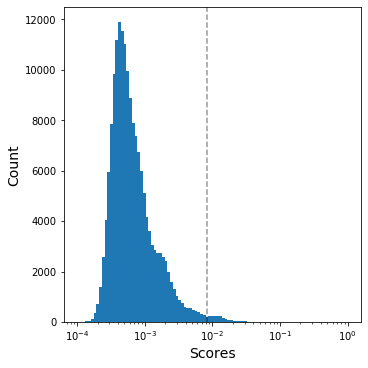

In [38]:
bins = np.logspace(-4,0,100)
fig,ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
ax.hist(scores_sorted,bins=bins)
ax.axvline(tabby_score,linestyle='--',c='black',alpha=.4)
ax.set_xlabel('Scores',fontsize=14)
ax.set_ylabel('Count',fontsize=14)
#plt.yscale('log')
plt.xscale('log')


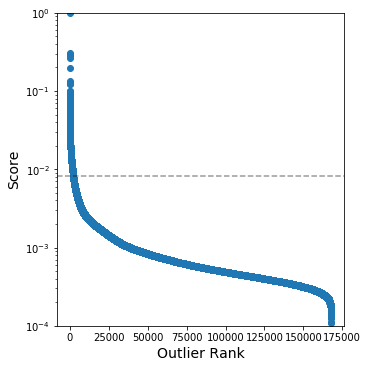

In [39]:
fig,ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
plt.scatter(range(len(scores_sorted)),scores_sorted)
ax.axhline(tabby_score,linestyle='--',c='black',alpha=.4)
ax.set_xlabel('Outlier Rank',fontsize=14)
ax.set_ylabel('Score',fontsize=14)
plt.ylim(1E-4,1E0)
plt.yscale('log')

The 'elbow' of the following plot can be thought of as the cutoff between 'outlying' points and 'normal' points. This elbow appears to occur somewhere around the 10,000th most outlying points in this log-scale plot, and closer to the 5,000th point in a linear scale plot.

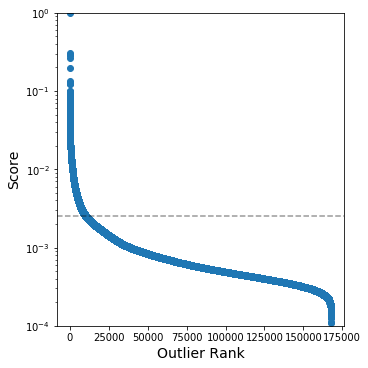

In [55]:
fig,ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
plt.scatter(range(len(scores_sorted)),scores_sorted)
ax.axhline(scores_sorted[10000],linestyle='--',c='black',alpha=.4)
ax.set_xlabel('Outlier Rank',fontsize=14)
ax.set_ylabel('Score',fontsize=14)
plt.ylim(1E-4,1E0) # zoomed in to better see the elbow.
plt.yscale('log')

(0, 0.1)

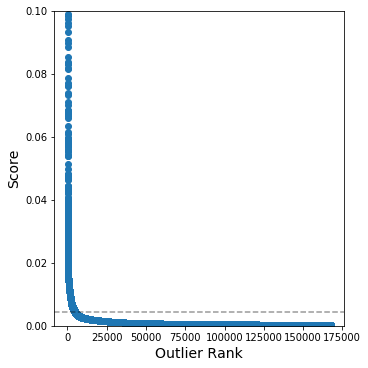

In [53]:
fig,ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
plt.scatter(range(len(scores_sorted)),scores_sorted)
ax.axhline(scores_sorted[5000],linestyle='--',c='black',alpha=.4)
ax.set_xlabel('Outlier Rank',fontsize=14)
ax.set_ylabel('Score',fontsize=14)
plt.ylim(0,.1) # zoomed in to better see the elbow.
